___

<center> Sébastien SIME | Data Scientist | Mauna LOA TSA </center>

___


Today we are going to study the trends in Atmospheric Carbon Dioxide at Mauna Loa (Hawaiʻi in the Pacific Ocean).

You can find the data [here](https://gml.noaa.gov/ccgg/trends/data.html). But instead of using the origina dataset, we will rather use a version of the latter.

The purpose of this notebook is to show how a time serie analysis can be performed in a easier way. I would like to think about this work as the ultimate workflow for time serie analysis (TSA).

In [6]:
# install pyramid ARIME
! pip install pmdarima

In [13]:
# Data path (TO CHANGE WHEN PUSHING ON GITHUB)
data_path = "/content/drive/MyDrive/Colab Notebooks/Time_series/co2_mm_mlo.csv"

# Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders (GAME CHANGER)
from statsmodels.tsa.stattools import adfuller               # Dickey-Fuller stationary test
from statsmodels.tsa.statespace.tools import diff            # differencing data


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Reading Data:

In [2]:
# read the data
co2_df = pd.read_csv(data_path)

# Show the head of the dataframe
co2_df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


Let's just observe couple of things here:

* The decimal_date column is essentially the year column
* the interpolated column is the average column with NA values filled with interpolated data
* The data date date is splitted into month and year

So, we can deduct that we have interpolated data of **monthly CO2 emission data**.



# Feature Engineering

In [3]:
# Creating a data column
co2_df['date'] = pd.to_datetime(dict(year=co2_df['year'], month=co2_df['month'], day=1))

# Set "date" to be the index
co2_df.set_index('date',inplace=True)

# specifying that we have monthly data
co2_df.index.freq = 'MS'

# show a view of the data
co2_df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


# Data visualization

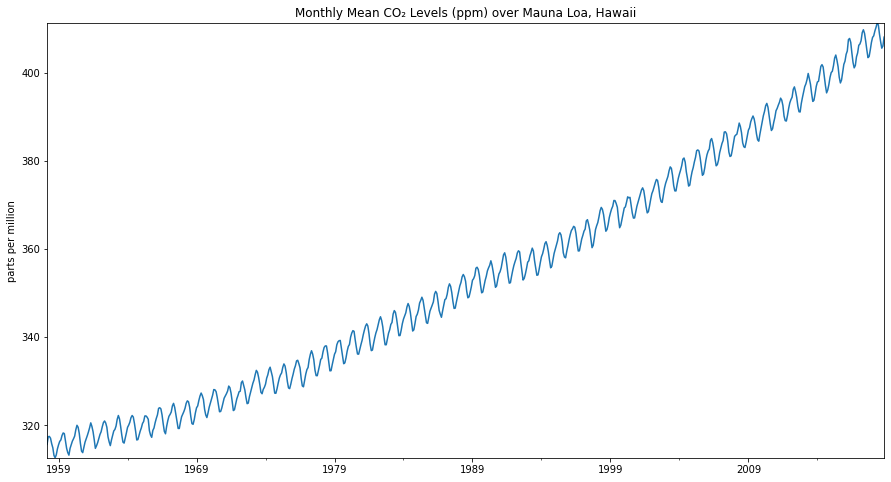

In [4]:
# plot the data
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii' # graph title
ylabel='parts per million' # y axis label
xlabel='' # hide x axis label
fig_size = (15, 8)

# Pandas plot
fig = plt.figure(figsize=fig_size)
ax = fig.subplots()
co2_df['interpolated'].plot(title = title, ax=ax).autoscale(axis='y', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

We observe some trend and seasonality in the data:

* The trend comes from the increasing tendensy from 1959 to almost 2010
* The seasonality comes from the pattern repeting itself

To be more clear, let's observe the data over 3 years to expose the cycle length (equal to a year so 12 month)

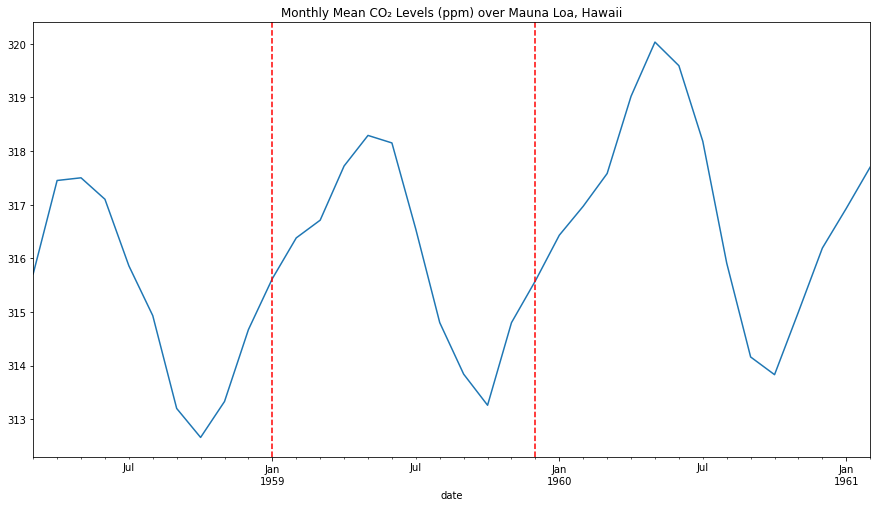

In [5]:
# Plot data over three years
ax = co2_df.interpolated[:36].plot(figsize=fig_size, title=title)
ax.axvline(x='1959-01-01', color='red', linestyle='--')
ax.axvline(x='1959-12-01', color='red', linestyle='--');

Now we would like to perform an Error-Trend-Seasonality decomposition to better asses the trend and the seasonality.

But to do that, we need to choose between using a additive or a multiplicative model.

There are actually three way of choosing:

1. Looking at the data plot to see if the range on a cycle is increasing with the time

2. Plot the decomposition with both additive and multiplicative models and compare the residual plots. The better model will exhibit a more random residual plot.

3. Use the Holt Winter method to model the data and see the one with better performance (with the least error)

Looking at our data, the increase in the data range is not quite obvious so this suggest a additive model could be used. To confirm, this let's:

* Use the Holt Winter method
* And plot the residuals with both models (additive and multiplicative)

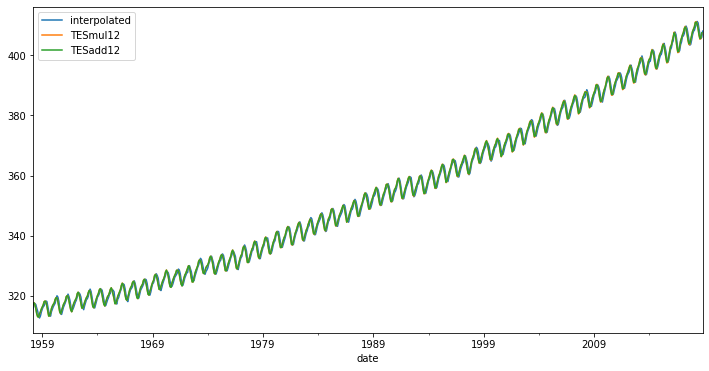

In [6]:
# Try a descriptive model: # Triple Exponential Smoothing (AKA Holt Winter Method)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# with multiplicative model
co2_df['TESmul12'] = ExponentialSmoothing(co2_df['interpolated'], 
                                          trend='mul',
                                          seasonal='mul',
                                          seasonal_periods=12).fit().fittedvalues.shift(-1)

# With additive model
co2_df['TESadd12'] = ExponentialSmoothing(co2_df['interpolated'], 
                                          trend='mul',
                                          seasonal='add',
                                          seasonal_periods=12).fit().fittedvalues.shift(-1)

# plot the results
col_list = ['interpolated', 'TESmul12', 'TESadd12']
co2_df[col_list].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

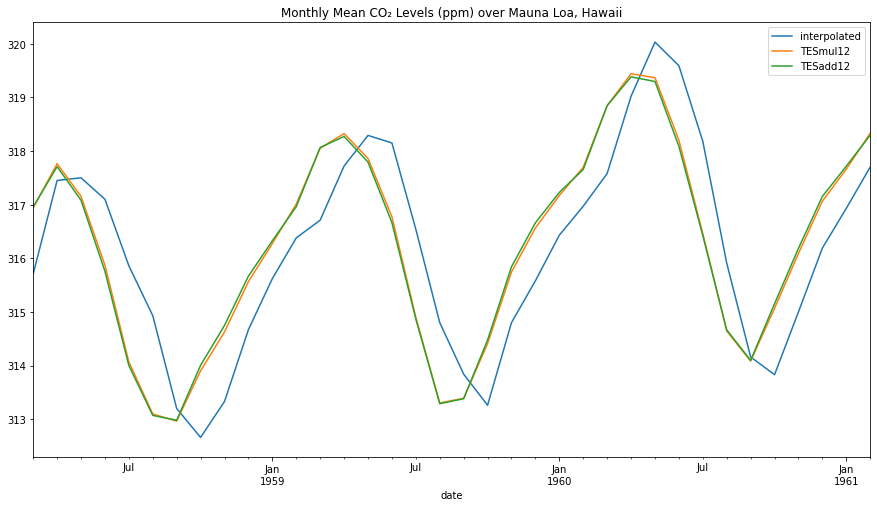

In [7]:
# Plot the results on three years (a zoom)
co2_df[col_list][:36].plot(figsize=fig_size, title=title);

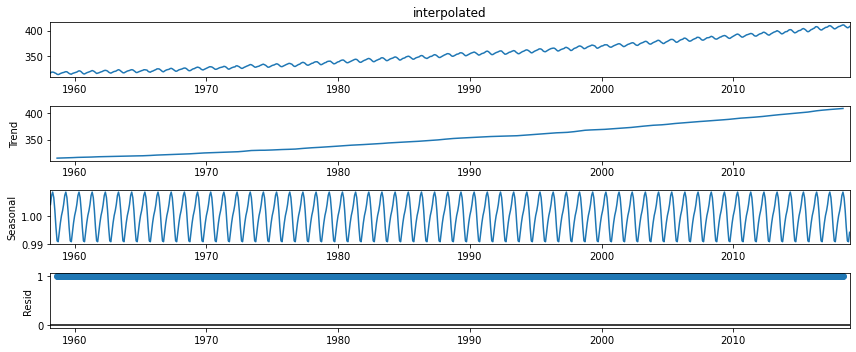

In [8]:
# Error-Trend-Seasonality (ETS) deocmposition
etsmul_results = seasonal_decompose(co2_df['interpolated'], model='mul')
etsadd_results = seasonal_decompose(co2_df['interpolated'], model='add')

# Decomposition with multiplicative model only
import pylab
pylab.rcParams['figure.figsize'] = (12, 5)
etsmul_results.plot();

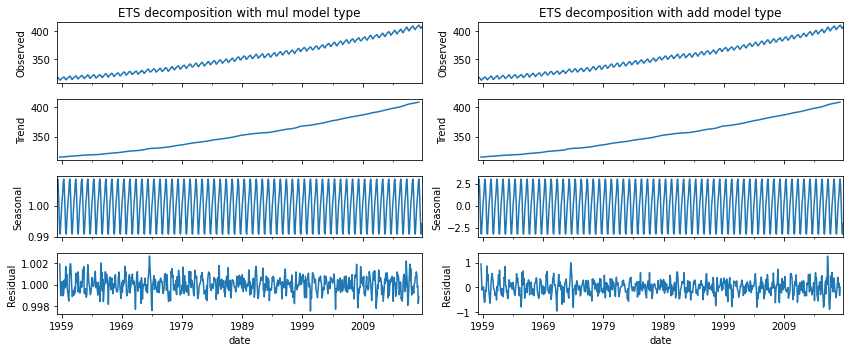

In [9]:
# plot the results
def ets_plot(res, axes, model_type ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(f'ETS decomposition with {model_type} model type')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

# Plot of all the decomposition
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
ets_plot(etsmul_results, axes[:,0], 'mul')
ets_plot(etsadd_results, axes[:,1], 'add')
plt.tight_layout()
plt.show()

## residual plots only (if neede)
#fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
#etsmul_results.resid.plot(ax=axes[0])
#axes[0].set_title('Residual with mul')
#etsadd_results.resid.plot(ax=axes[1])
#axes[1].set_title('residual with Add');

We see that the additive model seems to be a good fit since:

* The residual with addive model is distributed around zero (0)
* The seasonal component is also distributed around zero (0)

Now we can focus on finding the parameters (p, d, q) and (P, D, Q, m) to plug into a SARIMA model with:

* The order p being the number of time lag to use for autoregression
* The degree d being the number of time the data should be diferentiated
* The order q being the size of the moving average windows
* The parameters P, D, Q and m being respectively the seasonal regression, differencing, moving average coefficient and the length of the seasonal cycle.

# Defining the SARIMA parameters

Generaly speaking, we have 2 ways of finding the rigth params:

* A **classic approach** combining ACF plot, PACF plot along with the Dickey-Fuller test

The classic approach is more iterative. The fist thing to do is to find the number of time the data should be differianted (i.e. the parameter d) using the Dickey-Fuller test (as we know that SARIMA model should be used on stationary data.

The stationary data can then be used to plot the ACF and PACF plots that can be further analyzed to find the parameters p and q. This is precisely where a significant amount of time could be spent since finding the right p and q paramaters require and extensive experience with both the data field and the method.

* An **automated approach**

The automated approach is basically a gridsearch procedure to find the combination of parameters than could perform better using the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)


So let's first find the d parameter using the classic approach.

In [12]:
def adf_test(series,title=''):
    """
    This function perform a Dickey-Fuller stationary test
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
#
adf_test(co2_df['interpolated'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.994847
p-value                   1.000000
# lags used              20.000000
# observations          708.000000
critical value (1%)      -3.439620
critical value (5%)      -2.865631
critical value (10%)     -2.568948
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [17]:
# apply a first differentiation
co2_df['d1'] = diff(co2_df['interpolated'],
               k_diff=1) # the number of differentiations

# Dickey-Fuller test
adf_test(co2_df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.200976
p-value                   0.000009
# lags used              20.000000
# observations          707.000000
critical value (1%)      -3.439633
critical value (5%)      -2.865637
critical value (10%)     -2.568952
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


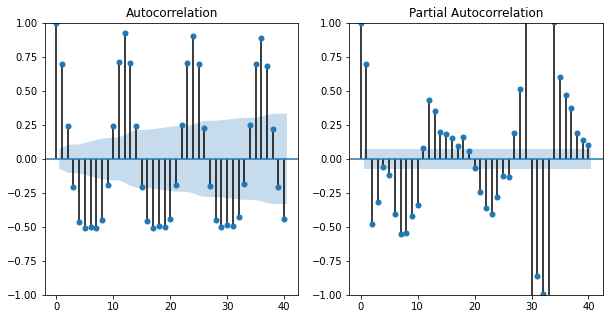

In [20]:
# ACF & PAF plots
acf_title = 'Autocorrelation'
pacf_title = 'Partial Autocorrelation'
lags = 40

# figure control
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
# ACF plot
plot_acf(co2_df['d1'].dropna(),title=acf_title,lags=lags, ax=axes[0])
# PACF plot
plot_pacf(co2_df['d1'].dropna(),title=pacf_title,lags=lags, ax=axes[1])
plt.show()

Looking at the ACF and PACF plots (applied on the stationary data) the only think I could say is that an higher MA term should be considered.

But how can we be sure?

Let's now introduce the automated approach that will give us directly the best parameters without too much husle.

For this we will use `the Pyramid ARIMA python library

In [21]:
# Automatic determination of sarima parameters
sarima_params_res = auto_arima(co2_df['interpolated'],
           seasonal=True, # WE want to account for the seasonality
           m=12)          # the length of our cycle (previously define = 12 month)


sarima_params_res.summary() #

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.693
Date:                              Fri, 24 Dec 2021   AIC                            423.387
Time:                                      17:09:26   BIC                            450.929
Sample:                                           0   HQIC                           434.014
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3549      0.034    -10.294      0.000      -0.422      -0.287
ma.L2         -0.0230      0.032     -0.712      0.476      -0.086       0.040
ma.L3         -0.0836      0.032     -2.607      0.009      -0.146      -0.021
ar.S.L12       0.9996      0.000   2988.504      0.000       0.999       1.000
ma.S.L12      -0.8666      0.021    -40.715      0.000      -0.908      -0.825
sigma2         0.0956      0.005     20.342      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 4.03
Prob(Q):                              0.77   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Get the paramaters:
arima_params = sarima_params_res.order
seasonal_params = sarima_params_res.seasonal_order

print(f'ARIMA parameters (p,d,q) = {arima_params}')
print(f'seasonal parameters (P,D,Q,m) =  {seasonal_params}')

ARIMA parameters (p,d,q) = (0, 1, 3)
seasonal parameters (P,D,Q,m) =  (1, 0, 1, 12)


The computation took about 5mins and 18 secs on Colab. And we are now ready to build our model!

# Train \ test split

We choose to perform our prediction over one year so our test dataset should be at least one year long.

In [25]:
# Length of the dataset
len(co2_df)

729

In [26]:
# Set one year for testing
train = co2_df.iloc[:717]
test = co2_df.iloc[717:]

# Fit SARIMA model

In [27]:
# model fitting
sarima_model = SARIMAX(train['interpolated'],
                       order=arima_params,
                       seasonal_order=seasonal_params)
results = sarima_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.190
Date:                              Fri, 24 Dec 2021   AIC                            414.380
Time:                                      17:15:40   BIC                            441.823
Sample:                                  03-01-1958   HQIC                           424.977
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3544      0.035    -10.114      0.000      -0.423      -0.286
ma.L2         -0.0246      0.027     -0.898      0.369      -0.078       0.029
ma.L3         -0.0862      0.033     -2.595      0.009      -0.151      -0.021
ar.S.L12       0.9996      0.000   2978.796      0.000       0.999       1.000
ma.S.L12      -0.8651      0.022    -38.820      0.000      -0.909      -0.821
sigma2         0.0951      0.005     20.299      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.32
Prob(Q):                              0.78   Prob(JB):                         0.12
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Perform prediction

In [31]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(
    start=start,                     # time to start
    end=end,                         # time to end 
    dynamic=False,                   # use the full history to forecast
    typ='levels'                     # predict at the level of the original data (and not at the level of the differentiated one)
    ).rename(f'SARIMA{str(arima_params)}{str(seasonal_params)} Predictions')

In [43]:
# compare results
results_df = pd.DataFrame(test['interpolated']).rename(columns={'interpolated':'Test'})
results_df[f'SARIMA{str(arima_params)}{str(seasonal_params)} Predictions'] = predictions

results_df.head()

,Test,"SARIMA(0, 1, 3)(1, 0, 1, 12) Predictions"
date,,
2017-12-01,406.81,406.610222
2018-01-01,407.96,407.825758
2018-02-01,408.32,408.579221
2018-03-01,409.41,409.484389
2018-04-01,410.24,411.042760


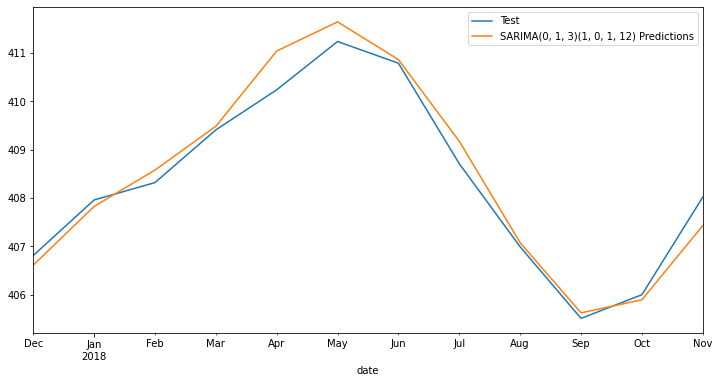

In [44]:
# plot results
results_df.plot(figsize=(12, 6));

# Evaluate the results

In [45]:
# librairies:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [46]:
# compute the errors
MSE_error = mean_squared_error(results_df['Test'], results_df['SARIMA(0, 1, 3)(1, 0, 1, 12) Predictions'])
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {MSE_error:11.10}')

RMSE_error = rmse(results_df['Test'], results_df['SARIMA(0, 1, 3)(1, 0, 1, 12) Predictions'])
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {RMSE_error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1284188981
SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3583558262


# Retrain the model on the full data, and forecast one year into the future!

In [47]:
# model instantiation
sarima_model_full = SARIMAX(co2_df['interpolated'],
                       order=arima_params,
                       seasonal_order=seasonal_params)
# Model fitting
full_results = sarima_model_full.fit()

# Forecast
future = 11
fcast = full_results.predict(len(co2_df),
                             len(co2_df)+future,
                             typ='levels').rename(f'SARIMA{str(arima_params)}{str(seasonal_params)} forecast')

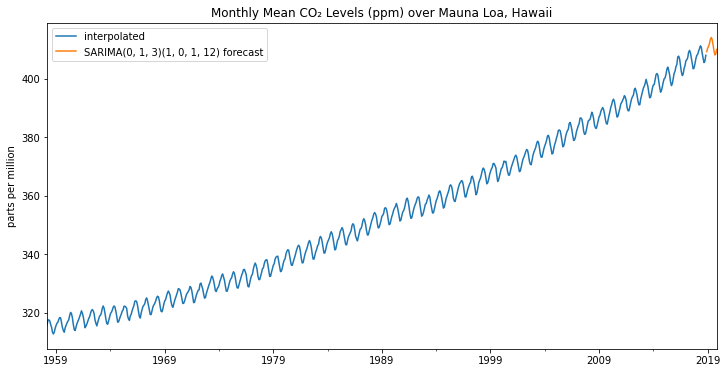

In [48]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = co2_df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Conclusion

We saw that only using the pmdarima library we were able to find more easily the model parameters.

Of course we always need to spend some time understanding our data to use the good hyperparameters.

If like myself, you were struggling finding the best SARIMA parameters, now you can do it  in a matter of minutes!


Regards,

Sébastien SIME | Data Scientist
___